Parameters that might affect performance
----------------------------------------

This notebook examines how parameters in the semantic model of the Danish language affects its performance.

- Number of pages read
- Use of stopwords
- Exclusion of short pages
- Scaling of matrix tfidf/count
- Normalization of document
- Factorization of matrix

In [1]:
from everything import *
from dasem.semantic import Semantic
from dasem.data import wordsim353 as wordsim353_data

In [2]:
# Read datasets
four_words = read_csv('../dasem/data/four_words.csv', encoding='utf-8')
wordsim353 = wordsim353_data()

In [3]:
def compute_accuracy(semantic, four_words):
    outlier = []
    for idx, words in four_words.iterrows():
        sorted_words = semantic.sort_by_outlierness(words.values[:4])
        outlier.append(sorted_words[0])

    accuracy = mean(four_words.word4 == outlier)
    return accuracy

In [4]:
def compute_correlation(semantic, wordsim):
    human = []
    relatednesses = []
    for idx, row in wordsim.iterrows():
        R = semantic.relatedness([row.da1, row.da2])
        relatednesses.append(R[0, 1])
        human.append(row['Human (mean)'])
    human = array(human)
    relatednesses = array(relatednesses)
    indices = (~isnan(relatednesses)).nonzero()[0]
    C = corrcoef(human[indices], relatednesses[indices])
    return C[0, 1]

In [5]:
max_n_pagess = [3000, 30000, None]
norms = ['l1', 'l2', None]
stop_wordss = [None, set(nltk.corpus.stopwords.words('danish'))]
use_idfs = [True, False]
sublinear_tfs = [True, False]

columns = ['accuracy', 'correlation', 'stop_words', 'use_idf', 'norm', 'sublinear_tf', 'max_n_pages']

n_total = len(max_n_pagess) * len(norms) * len(stop_wordss) * len(use_idfs) * \
    len(sublinear_tfs)
results = DataFrame(dtype=float, index=range(n_total), columns=columns)

n = 0
for stop_words_index, stop_words in (enumerate(stop_wordss)):
    for norm in (norms):
        for use_idf in (use_idfs):
            for sublinear_tf in (sublinear_tfs):
                for max_n_pages in (max_n_pagess):
                    results.ix[n, 'max_n_pages'] = max_n_pages
                    results.ix[n, 'stop_words'] = stop_words_index
                    results.ix[n, 'norm'] = str(norm)
                    results.ix[n, 'use_idf'] = use_idf
                    results.ix[n, 'sublinear_tf'] = sublinear_tf
                    semantic = Semantic(stop_words=stop_words, norm=norm,
                                        use_idf=use_idf, sublinear_tf=sublinear_tf,
                                        max_n_pages=max_n_pages)
                    results.ix[n, 'accuracy'] = compute_accuracy(semantic, four_words)
                    results.ix[n, 'correlation'] = compute_correlation(semantic, wordsim353)
                    n += 1

In [6]:
relatednesses = []
for idx, row in wordsim353.iterrows():
    R = semantic.relatedness([row.da1, row.da2])
    relatednesses.append(R[0, 1])
wordsim353['relatedness'] = relatednesses

In [7]:
wordsim353

,Word 1,da1,Word 2,da2,Human (mean),Problem,relatedness
0,love,kærlighed,sex,sex,6.77,NaN,0.069031
1,tiger,tiger,cat,kat,7.35,NaN,0.024325
2,tiger,tiger,tiger,tiger,10.00,NaN,1.000000
3,book,bog,paper,papir,7.46,NaN,0.031266
4,computer,computer,keyboard,tastatur,7.62,NaN,0.117331
5,computer,computer,internet,internet,7.58,NaN,0.059367
6,plane,fly,car,bil,5.77,NaN,0.013637
7,train,tog,car,bil,6.31,NaN,0.026891
8,telephone,telefon,communication,kommunikation,7.50,NaN,0.007303
9,television,tv,radio,radio,6.77,NaN,0.164519


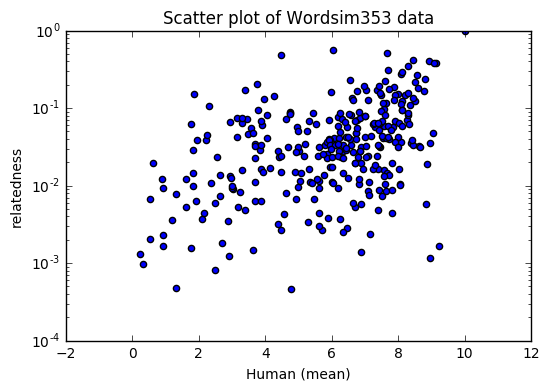

In [12]:
wordsim353.plot(x='Human (mean)', y='relatedness', kind='scatter')
yscale('log')
ylim(0.0001, 1)
title('Scatter plot of Wordsim353 data')
show()

In [9]:
results

,accuracy,correlation,stop_words,use_idf,norm,sublinear_tf,max_n_pages
0,0.36,0.274049,0.0,True,l1,True,3000.0
1,0.56,0.210682,0.0,True,l1,True,30000.0
2,0.72,0.135028,0.0,True,l1,True,NaN
3,0.34,0.292945,0.0,True,l1,False,3000.0
4,0.60,0.216162,0.0,True,l1,False,30000.0
5,0.74,0.137733,0.0,True,l1,False,NaN
6,0.38,0.279397,0.0,False,l1,True,3000.0
7,0.56,0.214376,0.0,False,l1,True,30000.0
8,0.72,0.138702,0.0,False,l1,True,NaN
9,0.36,0.292561,0.0,False,l1,False,3000.0


In [10]:
formula = 'accuracy ~ stop_words + use_idf + norm + sublinear_tf + max_n_pages'
model = smf.glm(formula, data=results).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               accuracy   No. Observations:                   48
Model:                            GLM   Df Residuals:                       41
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:               0.000536585365854
Method:                          IRLS   Log-Likelihood:                 116.40
Date:                Tue, 11 Oct 2016   Deviance:                     0.022000
Time:                        01:13:12   Pearson chi2:                   0.0220
No. Iterations:                     2                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3713      0.009     40.567      0.000       0.353       0.389
use_idf[T.True]          0.0017      0.007      0.249      0.803      -0.011       0.015
norm[T.l1]              -0.0250      0.008     -3.053      0.002      -0.041      -0.009
norm[T.l2]            1.509e-16      0.008   1.84e-14      1.000      -0.016       0.016
sublinear_tf[T.True]    -0.0017      0.007     -0.249      0.803      -0.015       0.011
stop_words            3.816e-17      0.007   5.71e-15      1.000      -0.013       0.013
max_n_pages           7.346e-06   2.48e-07     29.660      0.000    6.86e-06    7.83e-06
========================================================================================
"""